# Report Team 9: Sustainable water resources in the United States

## 1. Executive Summary

Today, the sustainable management of water resources is a key objective our team decided to tackle. In the meantime, water pollution and water consumption are two significant threats to this endeavor that we thought could be analyzed using the datasets available. Therefore, the issue around which our report is organized is the following:

#### Which economic factors are most predictive of high water pollution and water consumption levels?

We followed similar steps to identify predictive factors to the two variables of water consumption and water pollution and proceeded as follows:

#### I. Definition of the variables to predict: water pollution and water consumption levels
#### II. Visualizations on a map of the US territory
#### III. Core work on features engineering and regression
#### IV. Conclusion

### Insights obtained

Blabla final

## 2. Technical exposition

#### Modules Import

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import lightgbm as lgb
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.tools as tls
tls.set_credentials_file(username='amaury.s', api_key='cxNz8wCOgQaMiGjiBN7k')

plt.rcParams['figure.figsize'] = (15.0, 10.0)

#### Datasets import

In [38]:
data_chemicals = pd.read_csv("chemicals.csv", encoding = "utf-8")
data_education = pd.read_csv("education_attainment.csv", encoding = "latin1")
data_industry_occupation = pd.read_csv("industry_occupation.csv", encoding="latin1")
data_industry_earnings = pd.read_csv("earnings.csv", encoding="latin1")

### 2.1 Analysis of water pollution

#### I. Water pollution definition

The definition of a proper water pollution metric proved challenging. First, we decided to focus on water pollution by chemicals: the only direct pollution measure available in the dataset, in the table **chemicals**:

In [39]:
data_chemicals.head()

,cws_name,chemical_species,contaminant_level,county,pws_id,pop_served,state,unit_measurement,value,year,fips,state_fips
0,CALIFORNIA WATER SERVICE - LIVERMORE,Uranium,Less than or equal MCL,Alameda,CA0110003,57200,California,micrograms/L,1.54,2000,6001,6
1,CITY OF LIVERMORE,Uranium,Less than or equal MCL,Alameda,CA0110011,26400,California,micrograms/L,1.64,2000,6001,6
2,CITY OF PLEASANTON,Uranium,Less than or equal MCL,Alameda,CA0110008,70600,California,micrograms/L,1.64,2000,6001,6
3,DUBLIN SAN RAMON SERVICES DISTRICT,Uranium,Less than or equal MCL,Alameda,CA0110009,72500,California,micrograms/L,1.64,2000,6001,6
4,NORRIS CANYON PROPERTY OWNERS ASSN,Uranium,Less than or equal MCL,Alameda,CA0103040,100,California,micrograms/L,4.51,2000,6001,6


- The geographical scale we retained is the **county**

The challenge is then to aggregate chemicals data in a sensible way at the county level. To do so, we chose the following **assumption and definition**:

- The **volume of water** consumed by human activities on a county's territory is assumed to be proportional to the total population of the county
- The **level of chemicals** spread in the volume of water distributed by a given water system **cws**, in a given county, is defined as the number $N$ of contaminants whose level in this water system is classified to 'greater_than_MCL'. This $N$ is then averaged on all the water systems in the county, with *weights* equal to the population supplied by each water system.

Given the above assumption on any county's water volume, the definition of a county's chemical level as a weighted averaged of contaminants in high concentrations is consistent, because the weights correspond to populations supplied by water systems and sum to the county's total population.

#### Data wrangling to obtain the chemicals_index:

In [40]:
data_chemicals['greater_than_MCL'] = (data_chemicals['contaminant_level'] == "Greater than MCL") * 1.
groups = data_chemicals.groupby(["year", "pws_id"])['pop_served', 'greater_than_MCL'].mean()
groups['greater_than_MCL'] *= data_chemicals.groupby(["year", "pws_id"])['greater_than_MCL'].count()
groups['index_weight'] = groups['pop_served'] * groups['greater_than_MCL']
final_groups = groups.groupby("year")['index_weight'].sum() / groups.groupby("year")['pop_served'].sum()

In [41]:
data_chemicals = data_chemicals[data_chemicals['year']==2010]
data_chemicals = data_chemicals.set_index(data_chemicals['fips'])
groups = data_chemicals.groupby("cws_name")[['greater_than_MCL', 'fips', "pop_served"]].mean()
groups['greater_than_MCL'] *= data_chemicals.groupby("cws_name")['greater_than_MCL'].count()
groups['index_with_weights'] = groups['greater_than_MCL']*groups['pop_served']
groups['fips'] = groups['fips'].astype(int)
chemicals_index = groups.groupby("fips")['index_with_weights'].sum() / groups.groupby("fips")['pop_served'].sum()

#### II. Visualization: countys with highest water pollution levels

In [42]:
eighty_quantile=chemicals_index.quantile(.75)
chemicals_index_eighty=chemicals_index[chemicals_index>eighty_quantile]

bins=[]

for q in np.linspace(0,1,5):
    bins.append(chemicals_index_eighty.quantile(q))

fig = ff.create_choropleth(fips=chemicals_index_eighty.index.values, values=chemicals_index_eighty,binning_endpoints=bins)
py.iplot(fig, filename="Top 75% polluted counties ")

C:\Users\User\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\pandas\core\frame.py:6211: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.


C:\Users\User\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\plotly\figure_factory\_county_choropleth.py:771: UserWarning:

Unrecognized FIPS Values

Whoops! It looks like you are trying to pass at least one FIPS value that is not in our shapefile of FIPS and data for the counties. Your choropleth will still show up but these counties cannot be shown.
Unrecognized FIPS are: [19633, 28473, 31868, 32261, 37520, 37606, 37608, 40423, 42012]



High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~amaury.s/0 or inside your plot.ly account where it is named 'Top 75% polluted counties '


This map shows the top 25% of counties with the highest water pollution levels. It seems that industrial states in the North-East and agricultural states in the center are most associated with high water pollution levels. Following this intuition, we tried to explain water pollution levels in any county by the relative share of each industry in those counties.

#### III. Features set 1: Industry shares in each county

First of all, we define the share of a given industry sector in a county as the percentage of the working population employed in this sector. More precisely:

$$ Industry\ share = 100 \times \frac{Population\ employed\ by\ industry}{Total\ working\ population\ in\ county}$$

**Hypothesis**: The shares of certain industry sectors is positively / negatively correlated with the pollution index.

*Remark: this approach does not differentiate between counties with large and small populations. This is roughly equivalent to assuming that a county's water reserves (which can be polluted by industries) are proportional to its population, which is a debatable assumption.*

Using a linear model, we build a predictive model of water pollution based on the industry share (both in 2010) of the following sectors:

- Agriculture
- Construction
- Manufacturing
- Wholesale trade
- Retail trade
- Transport and utilities
- Information
- Finance, insurance and real estate
- prof_scientific_waste
- Education and health
- Arts and entertainment
- Public administration
- Other

This leads to the following weights:

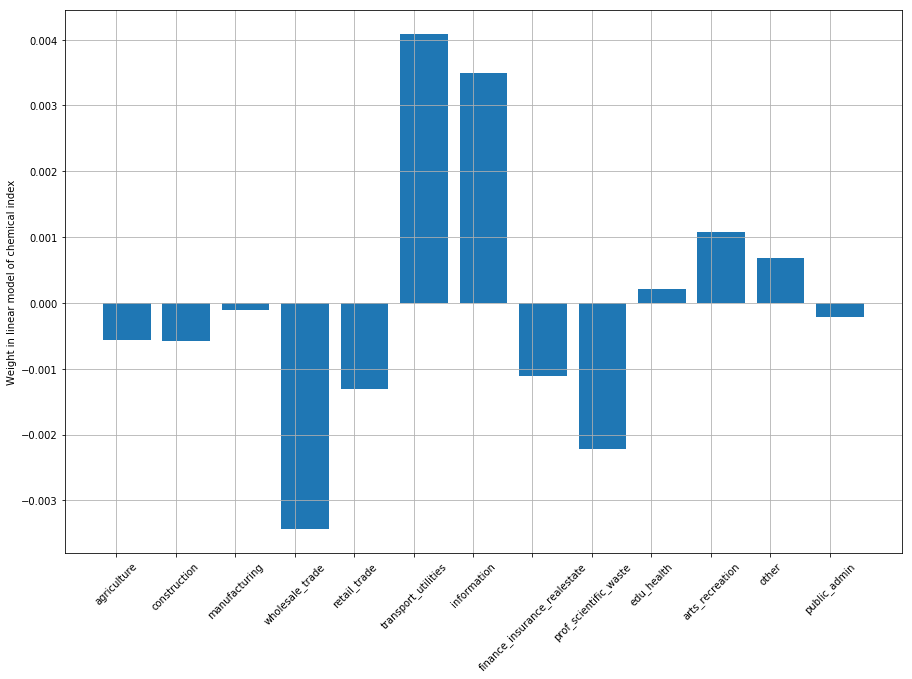

In [43]:
data_industry_earnings = data_industry_earnings[data_industry_earnings['year'] == 2010]
data_industry_occupation = data_industry_occupation[data_industry_occupation['year'] == 2010]

data_industry_occupation = data_industry_occupation.set_index(data_industry_occupation['fips'])
data_industry_earnings = data_industry_earnings.set_index(data_industry_earnings['fips'])

sectors_occupation = ['agriculture', 'construction', 'manufacturing', 'wholesale_trade', 'retail_trade', 'transport_utilities', 'information', 'finance_insurance_realestate', 'prof_scientific_waste', 'edu_health', 'arts_recreation', 'other', 'public_admin']
industry_occ_pop = data_industry_occupation[sectors_occupation]
industry_occ_pop['chemicals'] = chemicals_index
industry_occ_pop['total_employed'] = data_industry_occupation['total_employed']
industry_occ_pop = industry_occ_pop.dropna()

for col in sectors_occupation:
    industry_occ_pop[col] = 100. * industry_occ_pop[col]/industry_occ_pop['total_employed']

X = industry_occ_pop[sectors_occupation]
Y = industry_occ_pop['chemicals']

L = Ridge()
L.fit(X, Y.values.reshape(-1,1))

ind = np.arange(len(L.coef_.flatten()))
width = 0.35
fig, ax = plt.subplots()
ax.bar(ind+width, L.coef_.flatten())
ax.set_xticks(ind+width/2.)
ax.set_xticklabels(sectors_occupation)
plt.xticks(rotation=45)
plt.grid()
plt.ylabel("Weight in linear model of chemical index")
plt.show()

#### Analysis of results

In [54]:
r2_score(Y.values.flatten(), L.predict(X))

0.11487477649726441

The above $R^{2}$ score is an *in sample* measure of the variance explained in the water pollution levels by our simple linear regression model.

#### III. Features set 2: Industry profitability

In this section, we investigate the link between the profitability of the various sectors and water pollution levels in U.S. counties. A good proxy for the profitability of an industry is the median revenue of the people it employs. To take account of the diversity of costs of living across the US, we instead consider these values relative to the median revenue in a given county (that is to say the profitability of a given sector w.r.t. the median revenue in the county). For a given sector, we then average these relative values across all counties in the US.

**Hypothesis**: the local profitability of some industries is positively or negatively correlated with the level of water pollution in a county.

We then fit a multivariate linear model to predict the level of water pollution given the county-level profitability of the following industry sectors:

- Agriculture, fishing and mining
- Construction
- Manufacturing
- Wholesale trade
- Retail trade
- Transport, warehouse and utilities
- Information
- Finance, insurance and real estate
- **total_prof_sci_mgmt_admin**
- Education, health and social
- Arts, entertainment and food
- Public administration
- Other services

We obtain the following weights for the various industries:

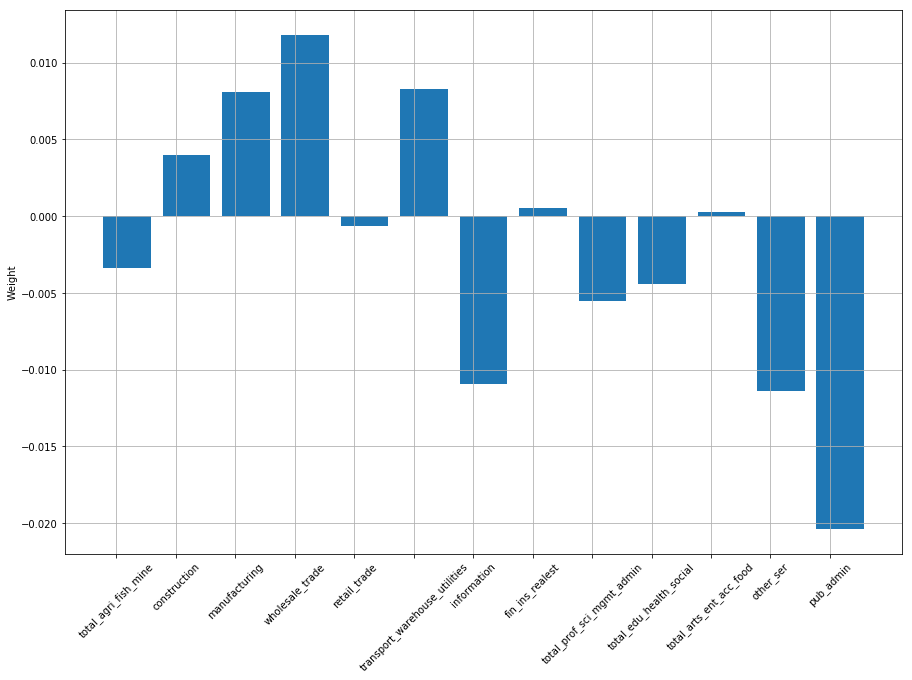

In [44]:
sectors_earnings = ['total_agri_fish_mine', 'construction', 'manufacturing', 'wholesale_trade', 'retail_trade', 'transport_warehouse_utilities', 'information', 'fin_ins_realest', 'total_prof_sci_mgmt_admin', 'total_edu_health_social', 'total_arts_ent_acc_food', 'other_ser', 'pub_admin']

for sector in sectors_earnings:
    if(data_industry_earnings[sector].dtype != float):
        data_industry_earnings[sector] = data_industry_earnings[sector].str.replace('-','')
        data_industry_earnings[sector] = data_industry_earnings[sector].str.replace('+','')
        data_industry_earnings[sector] = data_industry_earnings[sector].str.replace(',','')
        data_industry_earnings[sector] = data_industry_earnings[sector].astype(float)

industry_earnings = data_industry_earnings[sectors_earnings]
industry_earnings['chemicals'] = chemicals_index
industry_earnings['total_med'] = data_industry_earnings['total_med']

for sector in sectors_earnings:
    industry_earnings[sector] = (industry_earnings[sector] - industry_earnings['total_med']) / industry_earnings['total_med']
    industry_earnings[sector] = (industry_earnings[sector] - industry_earnings[sector].mean()) / industry_earnings[sector].std()

industry_earnings = industry_earnings.dropna()

X = industry_earnings[sectors_earnings]
Y = industry_earnings['chemicals']

L = Ridge()
L.fit(X.values, Y.values.reshape(-1,1))

ind = np.arange(len(L.coef_.flatten()))
width = 0.35
fig, ax = plt.subplots()
ax.bar(ind+width, L.coef_.flatten())
ax.set_xticks(ind+width/2.)
ax.set_xticklabels(sectors_earnings)
plt.xticks(rotation=45)
plt.grid()
plt.ylabel("Weight")
plt.show()

#### IV. Conclusion

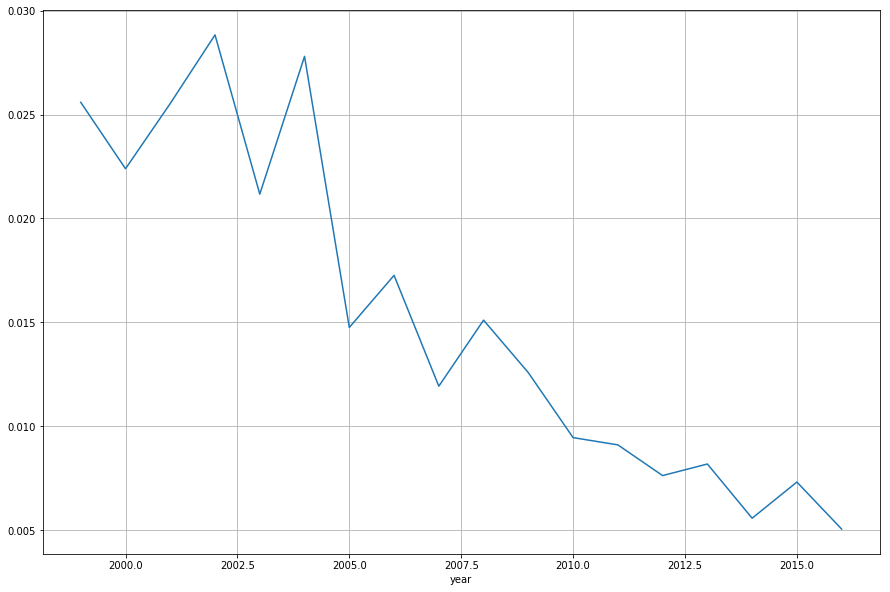

In [45]:
final_groups.plot()
plt.grid()

### 2.2 Analysis of water consumption

In [46]:
data_water = pd.read_csv("water_usage.csv")

#### I. Water consumption dataset

Water consumption data is available in the **water_usage** table

In [47]:
data_water.head()

,state,state_fips,county,county_fips,fips,year,population,pub_sup_1,pub_sup_2,pub_sup_3,...,thermoelectric_30,gro_wat_1,gro_wat_2,gro_wat_3,surf_wat_1,surf_wat_2,surf_wat_3,total_withdrawal_1,total_withdrawal_2,total_withdrawal_3
0,AL,1,Autauga County,1,1001,2010,54.571,NaN,NaN,48.222,...,6738.26,18.38,0.0,18.38,37.17,0.0,37.17,55.55,0.0,55.55
1,AL,1,Baldwin County,3,1003,2010,182.265,NaN,NaN,153.463,...,0.00,57.35,0.0,57.35,7.01,0.0,7.01,64.36,0.0,64.36
2,AL,1,Barbour County,5,1005,2010,27.457,NaN,NaN,25.555,...,0.00,6.71,0.0,6.71,4.34,0.0,4.34,11.05,0.0,11.05
3,AL,1,Bibb County,7,1007,2010,22.915,NaN,NaN,21.279,...,0.00,6.06,0.0,6.06,1.55,0.0,1.55,7.61,0.0,7.61
4,AL,1,Blount County,9,1009,2010,57.322,NaN,NaN,44.464,...,0.00,4.04,0.0,4.04,53.04,0.0,53.04,57.08,0.0,57.08


We quickly realize that we need to cut down the number of columns to only keep the most relevant ones:

#### Data cleaning:

In [48]:
data_water = data_water.loc[data_water['year']==2010]
data_water = data_water.drop(['state','state_fips','county','county_fips','year'],axis=1)
for name in ['pub_sup','dom_sup','ind','irrigation','crop','golf','livestock','aqua','mining','thermoelectric','gro_wat','surf_wat','total']:
    cols_name = [n for n in data_water.columns if n.startswith(name)]
    cols_name.sort(key=lambda n : int(n.split('_')[-1]))
    col_kept = cols_name[-1]
    
    data_water['_'.join(col_kept.split('_')[:-1])] = data_water[col_kept]
    data_water = data_water.drop(cols_name,axis=1)
    
data_water = data_water.set_index('fips')

#### II. Visualization: countys with highest water consumption levels

In [49]:
total_water = data_water['total_withdrawal']

eighty_quantile=total_water.quantile(.75)
total_water_eighty=total_water[total_water>eighty_quantile]

bins=[]

for q in np.linspace(0,1,5):
    bins.append(total_water_eighty.quantile(q))

fig = ff.create_choropleth(fips=total_water_eighty.index.values, values=total_water_eighty,binning_endpoints=bins)
py.iplot(fig, filename="Top 25% water consumption counties ")

C:\Users\User\AppData\Local\conda\conda\envs\tf-gpu\lib\site-packages\pandas\core\frame.py:6211: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




This map shows the top 25% of counties with the highest water consumption levels.

In [57]:
data_drought = pd.read_csv("droughts.csv")

data_drought=data_drought[data_drought['valid_start'].str.startswith('2010')]

data_drought['valid_start'] = pd.to_datetime(data_drought['valid_start'])
data_drought['valid_end'] = pd.to_datetime(data_drought['valid_end'])
data_drought['event_duration_in_days'] = (data_drought['valid_end'] - data_drought['valid_start']).dt.days
data_drought['event_importance_with_weight'] = data_drought['event_duration_in_days'] * 0. + (data_drought['d0']*1. + data_drought['d1']*2. + data_drought['d2']*3. + data_drought['d3']*4. + data_drought['d4']*5.) / 100.
groups = data_drought.groupby("fips")
drought_index = groups['event_importance_with_weight'].sum() / groups['event_duration_in_days'].sum()



eighty_quantile=drought_index.quantile(.75
drought_index_eighty=drought_index[drought_index>eighty_quantile]

bins=[]

for q in np.linspace(0,1,5):
    bins.append(drought_index_eighty.quantile(q))

fig = ff.create_choropleth(fips=drought_index_eighty.index.values, values=drought_index_eighty,binning_endpoints=bins)
py.iplot(fig, filename="Top 25% drought-stricken counties ")

TODO On phrase sur 2010 pas top

In [59]:
data_drought = pd.read_csv("droughts.csv")

data_drought['valid_start'] = pd.to_datetime(data_drought['valid_start'])
data_drought['valid_end'] = pd.to_datetime(data_drought['valid_end'])
data_drought['event_duration_in_days'] = (data_drought['valid_end'] - data_drought['valid_start']).dt.days
data_drought['event_importance_with_weight'] = data_drought['event_duration_in_days'] * 0. + (data_drought['d0']*1. + data_drought['d1']*2. + data_drought['d2']*3. + data_drought['d3']*4. + data_drought['d4']*5.) / 100.
groups = data_drought.groupby("fips")
drought_index = groups['event_importance_with_weight'].sum() / groups['event_duration_in_days'].sum()



eighty_quantile=drought_index.quantile(.75)
drought_index_eighty=drought_index[drought_index>eighty_quantile]

bins=[]

for q in np.linspace(0,1,5):
    bins.append(drought_index_eighty.quantile(q))

fig = ff.create_choropleth(fips=drought_index_eighty.index.values, values=drought_index_eighty,binning_endpoints=bins)
py.iplot(fig, filename="Top 25% drought-stricken counties ")

TODO phraser sur l'average, embrayer sur les industry shares

#### III. Features set 0: Water usage / Industry shares correlation 

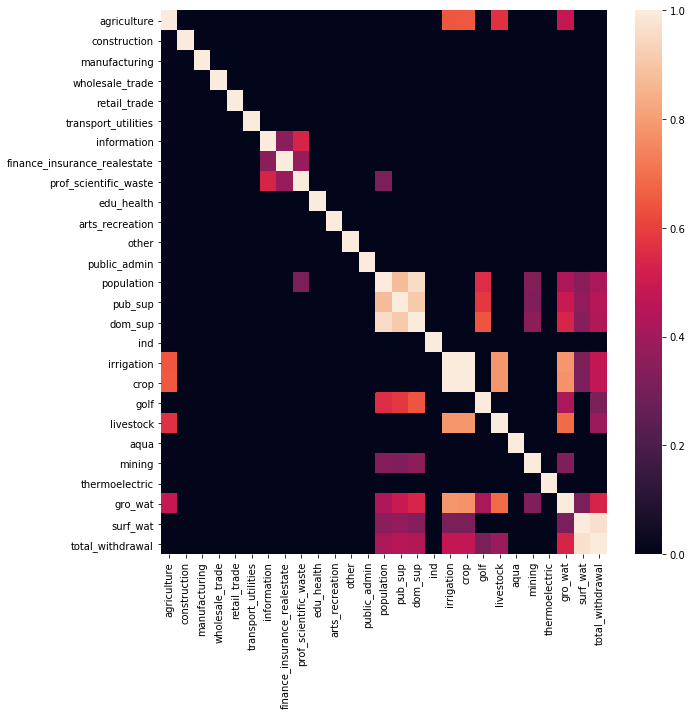

In [50]:
data_industry_occupation = pd.read_csv("industry_occupation.csv", encoding="latin1")
data_industry_occupation = data_industry_occupation[data_industry_occupation['year'] == 2010]
data_industry_occupation = data_industry_occupation.set_index(data_industry_occupation['fips'])


sectors_occupation = ['agriculture', 'construction', 'manufacturing', 'wholesale_trade', 'retail_trade', 'transport_utilities', 'information', 'finance_insurance_realestate', 'prof_scientific_waste', 'edu_health', 'arts_recreation', 'other', 'public_admin']
industry_occ_pop = data_industry_occupation[sectors_occupation]
industry_occ_pop['total_employed'] = data_industry_occupation['total_employed']
industry_occ_pop = industry_occ_pop.dropna()

for col in sectors_occupation:
    industry_occ_pop[col] = 100. * industry_occ_pop[col]/industry_occ_pop['total_employed']

occupation_joined_consumption = industry_occ_pop[sectors_occupation].join(data_water,how='inner')
occupation_joined_consumption = occupation_joined_consumption.dropna()


# calculate the correlation matrix
corr = occupation_joined_consumption.corr()
corr[corr<.3]=0

# plot the heatmap
plt.figure(figsize=(10,10))
sns.heatmap(corr, 
        xticklabels=occupation_joined_consumption.columns,
        yticklabels=occupation_joined_consumption.columns)
plt.show()

#### III. Features set 1: Industry shares

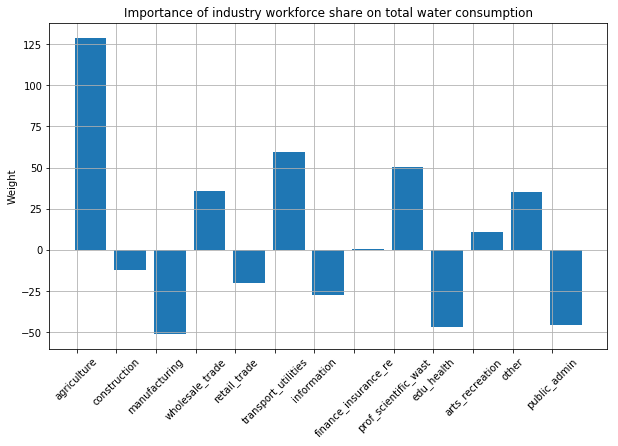

In [60]:
X=occupation_joined_consumption[sectors_occupation]
Y= occupation_joined_consumption['total_withdrawal']
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

L = Ridge(alpha=1e-3)
L.fit(X, Y.values.reshape(-1,1))
ind = np.arange(len(L.coef_.flatten()))
width = 0.35
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(ind+width, L.coef_.flatten())
ax.set_xticks(ind)
ax.set_xticklabels([x[:20] for x in sectors_occupation])
plt.xticks(rotation=45)
plt.grid()
plt.ylabel("Weight")
plt.title("Importance of industry workforce share on total water consumption")
plt.show()

#### III. Features set 2: Industry profitability

TODO Features description

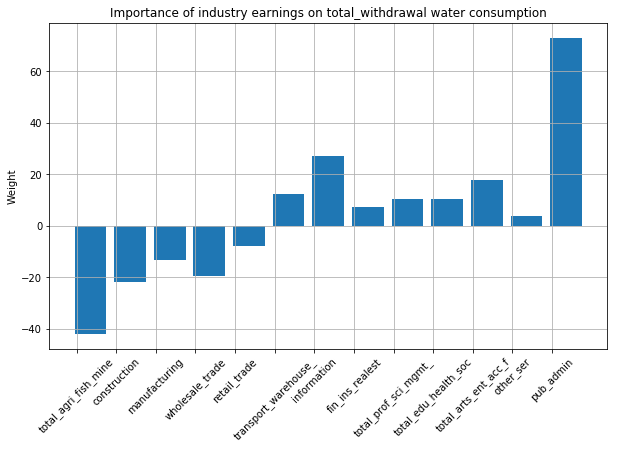

In [62]:
water_column='total_withdrawal'

joined_water_earnings=data_water.join(industry_earnings,how='inner')
joined_water_earnings = joined_water_earnings.dropna()
X= joined_water_earnings[sectors_earnings]
Y=joined_water_earnings[water_column]

X = StandardScaler().fit_transform(X)
L = Ridge(alpha=1e-2)
L.fit(X, Y.values.reshape(-1,1))
ind = np.arange(len(L.coef_.flatten()))
width = 0.35
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(ind+width, L.coef_.flatten())
ax.set_xticks(ind)
ax.set_xticklabels([x[:20] for x in sectors_earnings])
plt.xticks(rotation=45)
plt.grid()
plt.ylabel("Weight")
plt.title("Importance of industry earnings on {0} water consumption".format(water_column))
plt.show()

#### Analysis of results
TODO

#### IV. Conclusion

TODO conclu a ecrire